# QF 627 Programming and Computational Finance
## Hack The Market Project | YU LINGFENG
#### ML on `SPY` with other feature inputs
#### trading account started from `$100,000`
#### trading period from `November 2004` through `October 2023`.
#### training period from `November 1993` through `October 2004`.

> For `input features` (`predictors`; `Xs`), we use (The variables used as predictors are as follows) ...

> `additional induced features`

* lagged log on volume changes;

> `Correlated assets`

* lagged log returns of stocks (APPLE, XEL, ADBE);
* currency exchange rates (USD/JPY and GBP/USD);
* indices (VIX, JP225, T-bill);

> `Technical indicators`

* 21-day, 63-day, and 252-day moving averages;
* 10-day, 30-day, and 200-day exponential moving averages;


## 👉 <a id = "top">Content Table</a> 👈 

## [Part 1. Supervised Machine Learning](#p1)

> ### <font color = red> Feature Engineering </font>
> ### <font color = red> Model Training and Testing </font>
> ### <font color = red> Model Selection </font>

## [Part 2. Back Testing](#p2)

> ### <font color = red> Feature Choices </font>
> ### <font color = red> Result Visualization </font>
> ### <font color = red> Performance Metrics </font>

## [Part 3. Top Strategy (ML)](#p3)

> ### <font color = red> Choice by overall assessment </font>
> ### <font color = red> Choice by Best Return </font>
> ### <font color = red> Choice by Least Drawdown </font>

## [Part 4. Self-Critique (ML)](#p4)

> ### <font color = red> Goal and Method </font>
> ### <font color = red> Survivorship Bias </font>
> ### <font color = red> Future improvement </font>

In [178]:
from pandas_datareader import data as pdr
import yfinance as yf
(
    yf
    .pdr_override()
)
import datetime
import warnings
warnings.filterwarnings("ignore")

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [180]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# ENSEMBLE

## Bagging (Bootstrapped Aggregation)
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor

# Multi-layer Perceptron (Neural Networks)
from sklearn.neural_network import MLPRegressor

In [181]:
def cal_Sharpe_lg_Rtn(Strategy, Capital):
    portfolio =\
    (
    pd
    .DataFrame(index = Strategy.index)
    .fillna(0.0)
    )
    portfolio_change =\
    (
    pd
    .DataFrame(index = Strategy.index)
    .fillna(0.0)
    )
    portfolio_sortino =\
    (
    pd
    .DataFrame(index = Strategy.index)
    .fillna(0.0)
    )
    
    Sharpe = []
    CAGR = []
    Sortino = []
    for col in Strategy:
        portfolio[col] = np.exp(Strategy[col].cumsum()) * Capital
        portfolio_change[f"{col} Rtn"] = portfolio[col].pct_change()
        portfolio_change[f"{col} Rtn"].fillna(0, inplace=True)
        
        portfolio_sortino[f"{col} Rtn"] =\
            np.where(portfolio_change[f"{col} Rtn"] < 0,
                     portfolio_change[f"{col} Rtn"], 0)
        
        Sharpe += [np.sqrt(252) *\
                   portfolio_change[f"{col} Rtn"].mean() / \
                   portfolio_change[f"{col} Rtn"].std()]
        Sortino += [np.sqrt(252) *\
                    portfolio_change[f"{col} Rtn"].mean()/\
                    (((portfolio_sortino[f"{col} Rtn"]**2).sum()/\
                   len(portfolio_sortino[f"{col} Rtn"]))**0.5)]

        CAGR += [((portfolio[col][-1] / Capital)**\
                (365/(Strategy.index[-1] -\
                    Strategy.index[0]).days) - 1)*100]

    return [portfolio, portfolio_change, CAGR, Sharpe, Sortino]

In [182]:
def cal_MDD(performs):
    MDD = \
    (
    pd
    .DataFrame(index = performs.index)
    .fillna(0.0)
    )
    strategy_name = performs.columns
    MDD['Max'] = performs[strategy_name].cummax()
    
    MDD['Drawdown'] = performs[strategy_name].iloc[:, 0] - MDD['Max']
    MDD['DD%'] = MDD['Drawdown'] / MDD['Max'] * 100
    
    MDD = MDD.dropna()
    
    MDD['DD_Flag'] = 0
    DD = []
    flag = 0
    nDD = 1
    
    for idx in MDD.index:
        if MDD.loc[idx]['Drawdown'] == 0:
            # flag is to rememeber if in DrawDown period
            if flag == 0:
                continue
            else:
                # a DD period is just ended
                # clear flag, ready for next DD seriel number
                flag = 0
                nDD += 1
        # if Drawdown < 0, entering a DD period
        else:
            flag = 1
            MDD.loc[idx, 'DD_Flag'] = nDD
            
    grouped = MDD[MDD['DD_Flag'] != 0].groupby('DD_Flag')
    index_values = performs

    for flags, group in grouped:
        
        s_date = group.index.min()
        e_date = group.index.max()
        # like how we opened position on the next day, close is also shifted
        if len(MDD[e_date:].index) > 1:
            e_date = MDD[e_date:].index[1]
 
        
        days = (e_date.to_pydatetime() - s_date.to_pydatetime()).days
        loss = group['Drawdown'].min()
        loss_pct = group['DD%'].min()

        DD += [[flags, s_date, e_date, days, loss, loss_pct]]
    DD = pd.DataFrame(DD)
    column_names = ['S/N', 'DD_start', 'DD_end', 'Days', 'DD_Max', 'DD%']
    
    DD.columns = column_names
    return [MDD, DD]

## <a id = "p1">1. </a> <font color = "green"> Supervised Machine Learning </font>  [back to table of contents](#top)

predict tomorrow’s index level (market movement) from the index levels of the past few days (including today).
The machine learning algorithms of choice are 
* `LinearRegression (LR)`, 
* `Least Absolute Shrinkage and Selection Operator (LASSO)`, 
* `ElasticNet (EN)`, 
* `DecisionTreeRegressor (CART)`,
* `KNeighborsRegressor (KNN)`,
* `Support Vector Machine (SVR)`,
* `RandomForestRegressor (RFR)`,
* `ExtraTreesRegressor (ETR)`,
* `GradientBoostingRegressor (GBR)`,
* `AdaBoostRegressor (ABR)`


In [183]:
start = '1993-11-01'
end = '2023-11-01'

train1 = '2003-11-01'
train2 = '2014-11-01'
test = '2004-11-01'

In [184]:
spy = pdr.get_data_yahoo('spy', start, end)
stock_ticker = ["AAPL", 'XEL', 'ADBE']
currency_ticker = ["DEXJPUS", "DEXUSUK"]
index_ticker = ["^VIX",'^N225', '^TNX']

stock_data = yf.download(stock_ticker, start, end)
currency_data = pdr.get_data_fred(currency_ticker, start, end)
index_data = yf.download(index_ticker, start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed


In [185]:
spy[test:]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-01,113.559998,113.839996,113.199997,113.510002,78.617935,36720900
2004-11-02,113.669998,114.570000,113.220001,113.550003,78.645638,56210000
2004-11-03,115.029999,115.360001,114.239998,114.980003,79.636078,76960200
2004-11-04,114.779999,116.669998,114.680000,116.550003,80.723457,55350300
2004-11-05,117.050003,117.639999,116.489998,117.279999,81.229042,63287200
...,...,...,...,...,...,...
2023-10-25,421.890015,421.920013,417.019989,417.549988,417.549988,94223200
2023-10-26,416.450012,417.329987,411.600006,412.549988,412.549988,115156800
2023-10-27,414.190002,414.600006,409.209991,410.679993,410.679993,107367700


In [186]:
spy

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-11-01,46.781250,47.000000,46.781250,46.968750,27.145966,36400
1993-11-02,46.906250,47.000000,46.656250,46.937500,27.127909,262100
1993-11-03,46.906250,46.906250,46.125000,46.343750,26.784756,479100
1993-11-04,46.343750,46.343750,45.812500,45.843750,26.495770,130400
1993-11-05,45.718750,46.062500,45.531250,46.062500,26.622189,363200
...,...,...,...,...,...,...
2023-10-25,421.890015,421.920013,417.019989,417.549988,417.549988,94223200
2023-10-26,416.450012,417.329987,411.600006,412.549988,412.549988,115156800
2023-10-27,414.190002,414.600006,409.209991,410.679993,410.679993,107367700


In [187]:
spy["return"] = np.log(spy["Adj Close"]/spy["Adj Close"].shift(1))
spy["lg_volm"] = np.log(spy["Volume"]/spy["Volume"].shift(1))

In [188]:
lags = 7
return_period = 1
cols = []
for lag in range(1, lags+1):
    col = f"lag_{lag}"
    spy[col] = spy["return"].shift(lag)
    cols.append(col)
    col = f"lg_volm_{lag}"
    spy[col] = spy["lg_volm"].shift(lag)
    cols.append(col)

Y = spy[["return"]]
X0 = spy[cols]

In [189]:
X0

,lag_1,lg_volm_1,lag_2,lg_volm_2,lag_3,lg_volm_3,lag_4,lg_volm_4,lag_5,lg_volm_5,lag_6,lg_volm_6,lag_7,lg_volm_7
Date,,,,,,,,,,,,,,
1993-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-11-03,-0.000665,1.974157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-11-04,-0.012730,0.603183,-0.000665,1.974157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-11-05,-0.010848,-1.301303,-0.012730,0.603183,-0.000665,1.974157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,0.007511,-0.158254,-0.001735,-0.296867,-0.012364,0.020581,-0.008825,0.259856,-0.013415,0.216793,-0.000046,-0.001439,0.010466,-0.232135
2023-10-26,-0.014456,0.181750,0.007511,-0.158254,-0.001735,-0.296867,-0.012364,0.020581,-0.008825,0.259856,-0.013415,0.216793,-0.000046,-0.001439
2023-10-27,-0.012047,0.200628,-0.014456,0.181750,0.007511,-0.158254,-0.001735,-0.296867,-0.012364,0.020581,-0.008825,0.259856,-0.013415,0.216793


In [190]:
X1 =\
    (
    pd
    .concat([np
             .log(stock_data.loc[ : , ("Adj Close", ('AAPL', "ADBE", "XEL"))
                                ]
                 )
             .diff(i) for i in [return_period, 
                                return_period * 3, 
                                return_period * 6, 
                                return_period * 12]
            ],
           axis = 1
           )
    .dropna()
).shift(1)
X1.columns =\
    (X1
     .columns
     .droplevel()
    )
X1.columns = \
    stock_ticker +\
    [item + '_3DT' for item in stock_ticker] +\
    [item + '_6DT' for item in stock_ticker] +\
    [item + '_12DT' for item in stock_ticker]

X1

,AAPL,XEL,ADBE,AAPL_3DT,XEL_3DT,ADBE_3DT,AAPL_6DT,XEL_6DT,ADBE_6DT,AAPL_12DT,XEL_12DT,ADBE_12DT
Date,,,,,,,,,,,,
1993-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-11-18,-0.014814,0.049393,-0.014904,0.053653,0.043084,-0.011940,0.106190,0.024391,0.009050,0.061557,-0.035507,-0.063975
1993-11-19,0.000000,0.006006,-0.006024,0.045810,0.087556,-0.012012,0.085653,0.018127,-0.014993,0.022641,-0.017805,-0.055815
1993-11-22,-0.011450,-0.018127,-0.006061,-0.026264,0.037271,-0.026988,0.054083,0.024693,-0.015083,0.046148,0.018462,-0.021053
1993-11-23,-0.015266,0.000000,0.006061,-0.026716,-0.012121,-0.006024,0.026937,0.030962,-0.017965,0.011312,0.037271,0.006061
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,0.002540,-0.001574,0.017588,-0.011579,-0.029547,0.000508,-0.029989,-0.020509,-0.008092,-0.023083,0.024161,0.029720
2023-10-26,-0.013583,-0.034735,0.006580,-0.010349,-0.037327,0.023306,-0.034749,-0.072079,-0.000672,-0.045082,-0.015518,0.031082
2023-10-27,-0.024913,-0.013251,0.005032,-0.035957,-0.049560,0.029199,-0.052240,-0.081358,0.007389,-0.066637,-0.035228,0.029027


In [191]:
X1['XEL']

Date
1993-11-17         NaN
1993-11-18    0.049393
1993-11-19    0.006006
1993-11-22   -0.018127
1993-11-23    0.000000
                ...   
2023-10-25   -0.001574
2023-10-26   -0.034735
2023-10-27   -0.013251
2023-10-30   -0.012050
2023-10-31    0.036369
Name: XEL, Length: 7542, dtype: float64

In [192]:
X2 =\
    (np
     .log(currency_data)
     .diff(return_period)
    ).shift(1)

X2

,DEXJPUS,DEXUSUK
DATE,,
1993-11-01,NaN,NaN
1993-11-02,NaN,NaN
1993-11-03,-0.006579,0.001215
1993-11-04,-0.002513,-0.001350
1993-11-05,0.008999,-0.001149
...,...,...
2023-10-26,0.000667,-0.002468
2023-10-27,0.003329,-0.002227
2023-10-30,-0.005599,0.003132


In [193]:
index_data

Adj Close                           Close                    \
                   ^N225   ^TNX       ^VIX         ^N225   ^TNX       ^VIX   
Date                                                                         
1993-11-01  19438.240234  5.560  11.780000  19438.240234  5.560  11.780000   
1993-11-02  19381.240234  5.606  11.740000  19381.240234  5.606  11.740000   
1993-11-03           NaN  5.606  13.260000           NaN  5.606  13.260000   
1993-11-04  18949.789062  5.665  14.680000  18949.789062  5.665  14.680000   
1993-11-05  18590.460938  5.728  14.970000  18590.460938  5.728  14.970000   
...                  ...    ...        ...           ...    ...        ...   
2023-10-25  31269.919922  4.953  20.190001  31269.919922  4.953  20.190001   
2023-10-26  30601.779297  4.845  20.680000  30601.779297  4.845  20.680000   
2023-10-27  30991.689453  4.845  21.270000  30991.689453  4.845  21.270000   
2023-10-30  30696.960938  4.875  19.750000  30696.960938  4.875  19.750000   
2023-10-31  30858.849609  4.875  18.139999  30858.849609  4.875  18.139999   

                    High                             Low                    \
                   ^N225   ^TNX       ^VIX         ^N225   ^TNX       ^VIX   
Date                                                                         
1993-11-01  19656.970703  5.560  12.190000  19375.240234  5.560  11.770000   
1993-11-02  19549.150391  5.732  12.370000  19342.029297  5.569  11.490000   
1993-11-03           NaN  5.639  13.870000           NaN  5.581  11.530000   
1993-11-04  19433.240234  5.665  15.160000  18949.789062  5.598  13.130000   
1993-11-05  18941.689453  5.753  16.459999  18470.349609  5.469  14.560000   
...                  ...    ...        ...           ...    ...        ...   
2023-10-25  31466.919922  4.959  21.240000  31195.580078  4.851  18.860001   
2023-10-26  30943.330078  4.983  21.959999  30567.609375  4.842  20.219999   
2023-10-27  31081.480469  4.892  22.070000  30687.330078  4.843  19.719999   
2023-10-30  30762.500000  4.922  21.160000  30538.289062  4.867  19.549999   
2023-10-31  30973.660156  4.880  19.860001  30552.650391  4.803  17.969999   

                    Open                         Volume            
                   ^N225   ^TNX       ^VIX        ^N225 ^TNX ^VIX  
Date                                                               
1993-11-01  19656.970703  5.560  12.020000          0.0  0.0  0.0  
1993-11-02  19437.039062  5.732  11.680000          0.0  0.0  0.0  
1993-11-03           NaN  5.589  11.720000          NaN  0.0  0.0  
1993-11-04  19373.640625  5.610  13.520000          0.0  0.0  0.0  
1993-11-05  18941.689453  5.685  14.570000          0.0  0.0  0.0  
...                  ...    ...        ...          ...  ...  ...  
2023-10-25  31302.509766  4.851  19.389999   78700000.0  0.0  0.0  
2023-10-26  30902.919922  4.964  21.780001   85600000.0  0.0  0.0  
2023-10-27  30713.789062  4.866  20.389999   89100000.0  0.0  0.0  
2023-10-30  30663.480469  4.896  21.129999  187000000.0  0.0  0.0  
2023-10-31  30694.960938  4.810  19.860001  134300000.0  0.0  0.0  

[7797 rows x 18 columns]

In [194]:
X3 =\
    (
    pd
    .concat([np
             .log(index_data.loc[ : , ("Adj Close", ('^N225', "^TNX", "^VIX"))
                                ]
                 )
             .diff(i) for i in [return_period, 
                                return_period * 3, 
                                return_period * 6, 
                                return_period * 12]
            ],
           axis = 1
           )
    .dropna()
).shift(1)
X3.columns =\
    (X3
     .columns
     .droplevel()
    )
X3.columns = \
    index_ticker +\
    [item + '_3DT' for item in index_ticker] +\
    [item + '_6DT' for item in index_ticker] +\
    [item + '_12DT' for item in index_ticker]

X3

,^VIX,^N225,^TNX,^VIX_3DT,^N225_3DT,^TNX_3DT,^VIX_6DT,^N225_6DT,^TNX_6DT,^VIX_12DT,^N225_12DT,^TNX_12DT
Date,,,,,,,,,,,,
1993-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-11-18,-0.007559,-0.000889,0.029989,-0.021029,-0.003728,0.155329,-0.000938,-0.000178,0.110584,-0.070849,0.011089,0.278943
1993-11-22,0.003176,0.012725,-0.060906,0.005061,0.005283,0.013054,0.002459,0.002286,0.065586,-0.064736,0.015576,0.221439
1993-12-02,-0.031501,0.005986,0.056271,-0.040795,0.042144,0.020973,-0.061824,0.038416,0.176302,-0.086194,0.034525,0.079833
1993-12-06,0.019283,-0.000865,-0.023410,0.082345,0.007993,-0.044162,0.022688,-0.006727,0.000000,-0.044111,0.026481,-0.111927
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24,-0.008346,-0.017620,-0.063710,-0.033083,-0.013550,0.058112,-0.041589,0.044160,0.052922,-0.002442,0.025328,0.096833
2023-10-26,0.002024,0.000413,-0.071205,-0.011786,-0.030120,-0.120532,-0.019027,0.026802,0.097368,0.002181,0.011638,0.083519
2023-10-27,-0.021598,-0.022046,0.023980,-0.012915,0.001446,0.015104,-0.045997,-0.012104,0.073216,-0.036725,0.040005,0.194191


In [195]:
T1 =\
    (
    pd
    .concat([spy.loc[ : , "Adj Close"]
             .rolling(window=i, min_periods = 1)
             .mean() for i in [21, 
                                63, 
                                252]
            ],
           axis = 1
           )

).shift(1)

T1.columns = ["SPY_MA21", "SPY_MA63", "SPY_MA252"]
T1

,SPY_MA21,SPY_MA63,SPY_MA252
Date,,,
1993-11-01,NaN,NaN,NaN
1993-11-02,27.145966,27.145966,27.145966
1993-11-03,27.136937,27.136937,27.136937
1993-11-04,27.019543,27.019543,27.019543
1993-11-05,26.888600,26.888600,26.888600
...,...,...,...
2023-10-25,428.467619,438.633751,412.695952
2023-10-26,428.070952,438.104394,412.872745
2023-10-27,427.428095,437.425601,413.006061


In [196]:
T2 =\
    (
    pd
    .concat([spy.loc[ : , "Adj Close"]
             .ewm(span=i, adjust=False)
             .mean() for i in [10, 
                                30, 
                                200]
            ],
           axis = 1
           )

).shift(1)

T2.columns = ["SPY_EMA10", "SPY_EMA30", "SPY_EMA200"]
T2

,SPY_EMA10,SPY_EMA30,SPY_EMA200
Date,,,
1993-11-01,NaN,NaN,NaN
1993-11-02,27.145966,27.145966,27.145966
1993-11-03,27.142683,27.144801,27.145786
1993-11-04,27.077605,27.121572,27.142194
1993-11-05,26.971817,27.081198,27.135761
...,...,...,...
2023-10-25,427.120760,431.587346,423.573816
2023-10-26,425.380619,430.681710,423.513877
2023-10-27,423.047777,429.511921,423.404784


In [197]:
X=\
(
    pd
    .concat([X0, X1, X2, X3, T1, T2],
            axis = 1)
)

X

,lag_1,lg_volm_1,lag_2,lg_volm_2,lag_3,lg_volm_3,lag_4,lg_volm_4,lag_5,lg_volm_5,...,^TNX_6DT,^VIX_12DT,^N225_12DT,^TNX_12DT,SPY_MA21,SPY_MA63,SPY_MA252,SPY_EMA10,SPY_EMA30,SPY_EMA200
1993-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,27.145966,27.145966,27.145966,27.145966,27.145966,27.145966
1993-11-03,-0.000665,1.974157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,27.136937,27.136937,27.136937,27.142683,27.144801,27.145786
1993-11-04,-0.012730,0.603183,-0.000665,1.974157,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,27.019543,27.019543,27.019543,27.077605,27.121572,27.142194
1993-11-05,-0.010848,-1.301303,-0.012730,0.603183,-0.000665,1.974157,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,26.888600,26.888600,26.888600,26.971817,27.081198,27.135761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-26,-0.014456,0.181750,0.007511,-0.158254,-0.001735,-0.296867,-0.012364,0.020581,-0.008825,0.259856,...,0.097368,0.002181,0.011638,0.083519,428.070952,438.104394,412.872745,425.380619,430.681710,423.513877
2023-10-27,-0.012047,0.200628,-0.014456,0.181750,0.007511,-0.158254,-0.001735,-0.296867,-0.012364,0.020581,...,0.073216,-0.036725,0.040005,0.194191,427.428095,437.425601,413.006061,423.047777,429.511921,423.404784
2023-10-30,-0.004543,-0.070035,-0.012047,0.200628,-0.014456,0.181750,0.007511,-0.158254,-0.001735,-0.296867,...,-0.006093,-0.030031,0.052978,0.279100,426.578571,436.703364,413.143285,420.799089,428.296958,423.278169
2023-10-31,0.011885,-0.215390,-0.004543,-0.070035,-0.012047,0.200628,-0.014456,0.181750,0.007511,-0.158254,...,-0.094619,-0.056912,0.034008,0.168344,426.012380,436.079784,413.307964,419.851981,427.477154,423.201670


In [198]:
X.columns

Index(['lag_1', 'lg_volm_1', 'lag_2', 'lg_volm_2', 'lag_3', 'lg_volm_3',
       'lag_4', 'lg_volm_4', 'lag_5', 'lg_volm_5', 'lag_6', 'lg_volm_6',
       'lag_7', 'lg_volm_7', 'AAPL', 'XEL', 'ADBE', 'AAPL_3DT', 'XEL_3DT',
       'ADBE_3DT', 'AAPL_6DT', 'XEL_6DT', 'ADBE_6DT', 'AAPL_12DT', 'XEL_12DT',
       'ADBE_12DT', 'DEXJPUS', 'DEXUSUK', '^VIX', '^N225', '^TNX', '^VIX_3DT',
       '^N225_3DT', '^TNX_3DT', '^VIX_6DT', '^N225_6DT', '^TNX_6DT',
       '^VIX_12DT', '^N225_12DT', '^TNX_12DT', 'SPY_MA21', 'SPY_MA63',
       'SPY_MA252', 'SPY_EMA10', 'SPY_EMA30', 'SPY_EMA200'],
      dtype='object')

In [199]:
Y

,return
Date,
1993-11-01,NaN
1993-11-02,-0.000665
1993-11-03,-0.012730
1993-11-04,-0.010848
1993-11-05,0.004760
...,...
2023-10-25,-0.014456
2023-10-26,-0.012047
2023-10-27,-0.004543


In [200]:
taget_index = Y.index
taget_index

DatetimeIndex(['1993-11-01', '1993-11-02', '1993-11-03', '1993-11-04',
               '1993-11-05', '1993-11-08', '1993-11-09', '1993-11-10',
               '1993-11-11', '1993-11-12',
               ...
               '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-23',
               '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27',
               '2023-10-30', '2023-10-31'],
              dtype='datetime64[ns]', name='Date', length=7554, freq=None)

In [201]:
taget_index = Y.index
data = pd\
    .concat([Y, X], axis = 1)\
    .loc[Y.index]

In [202]:
data.ffill(inplace=True)
data.dropna(inplace = True)
data

,return,lag_1,lg_volm_1,lag_2,lg_volm_2,lag_3,lg_volm_3,lag_4,lg_volm_4,lag_5,...,^TNX_6DT,^VIX_12DT,^N225_12DT,^TNX_12DT,SPY_MA21,SPY_MA63,SPY_MA252,SPY_EMA10,SPY_EMA30,SPY_EMA200
Date,,,,,,,,,,,,,,,,,,,,,
1993-11-18,-0.002689,-0.005358,-2.520868,0.004687,0.705402,-0.000671,0.810314,0.004706,0.196469,-0.002692,...,0.110584,-0.070849,0.011089,0.278943,26.843097,26.843097,26.843097,26.892580,26.973543,27.109093
1993-11-19,-0.002023,-0.002689,1.805138,-0.005358,-2.520868,0.004687,0.705402,-0.000671,0.810314,0.004706,...,0.110584,-0.070849,0.011089,0.278943,26.841512,26.841512,26.841512,26.879547,26.963695,27.106225
1993-11-22,-0.006091,-0.002023,-0.820528,-0.002689,1.805138,-0.005358,-2.520868,0.004687,0.705402,-0.000671,...,0.065586,-0.064736,0.015576,0.221439,26.836523,26.836523,26.836523,26.859027,26.950985,27.102847
1993-11-23,0.005416,-0.006091,0.444323,-0.002023,-0.820528,-0.002689,1.805138,-0.005358,-2.520868,0.004687,...,0.065586,-0.064736,0.015576,0.221439,26.821999,26.821999,26.821999,26.812684,26.928608,27.097885
1993-11-24,0.004044,0.005416,-0.611291,-0.006091,0.444323,-0.002023,-0.820528,-0.002689,1.805138,-0.005358,...,0.065586,-0.064736,0.015576,0.221439,26.817682,26.817682,26.817682,26.801034,26.916995,27.094409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,-0.014456,0.007511,-0.158254,-0.001735,-0.296867,-0.012364,0.020581,-0.008825,0.259856,-0.013415,...,0.052922,-0.002442,0.025328,0.096833,428.467619,438.633751,412.695952,427.120760,431.587346,423.573816
2023-10-26,-0.012047,-0.014456,0.181750,0.007511,-0.158254,-0.001735,-0.296867,-0.012364,0.020581,-0.008825,...,0.097368,0.002181,0.011638,0.083519,428.070952,438.104394,412.872745,425.380619,430.681710,423.513877
2023-10-27,-0.004543,-0.012047,0.200628,-0.014456,0.181750,0.007511,-0.158254,-0.001735,-0.296867,-0.012364,...,0.073216,-0.036725,0.040005,0.194191,427.428095,437.425601,413.006061,423.047777,429.511921,423.404784


In [203]:
data.columns

Index(['return', 'lag_1', 'lg_volm_1', 'lag_2', 'lg_volm_2', 'lag_3',
       'lg_volm_3', 'lag_4', 'lg_volm_4', 'lag_5', 'lg_volm_5', 'lag_6',
       'lg_volm_6', 'lag_7', 'lg_volm_7', 'AAPL', 'XEL', 'ADBE', 'AAPL_3DT',
       'XEL_3DT', 'ADBE_3DT', 'AAPL_6DT', 'XEL_6DT', 'ADBE_6DT', 'AAPL_12DT',
       'XEL_12DT', 'ADBE_12DT', 'DEXJPUS', 'DEXUSUK', '^VIX', '^N225', '^TNX',
       '^VIX_3DT', '^N225_3DT', '^TNX_3DT', '^VIX_6DT', '^N225_6DT',
       '^TNX_6DT', '^VIX_12DT', '^N225_12DT', '^TNX_12DT', 'SPY_MA21',
       'SPY_MA63', 'SPY_MA252', 'SPY_EMA10', 'SPY_EMA30', 'SPY_EMA200'],
      dtype='object')

In [204]:
CORR = data.corr()
eff_value = abs(CORR.iloc[1:, 0]).mean() *0.75

X_choice = list(CORR[abs(CORR['return'])>eff_value].index[1:])
X_choice

['lag_1',
 'lag_2',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lg_volm_7',
 'AAPL',
 'XEL',
 'ADBE',
 'AAPL_3DT',
 'XEL_3DT',
 'ADBE_3DT',
 'AAPL_6DT',
 'XEL_6DT',
 'ADBE_6DT',
 'ADBE_12DT',
 '^N225',
 '^TNX',
 '^VIX_6DT',
 '^N225_6DT',
 '^TNX_6DT',
 '^VIX_12DT']

In [205]:
eff_value

0.01572810943361668

In [206]:
X_choice = [
 'lag_4',
 'AAPL',
 'XEL',
 'ADBE',
 '^N225',
 '^TNX']

In [207]:
data[X_choice]

,lag_4,AAPL,XEL,ADBE,^N225,^TNX
Date,,,,,,
1993-11-18,0.004706,-0.014814,0.049393,-0.014904,-0.000889,0.029989
1993-11-19,-0.000671,0.000000,0.006006,-0.006024,-0.000889,0.029989
1993-11-22,0.004687,-0.011450,-0.018127,-0.006061,0.012725,-0.060906
1993-11-23,-0.005358,-0.015266,0.000000,0.006061,0.012725,-0.060906
1993-11-24,-0.002689,0.015266,0.076283,0.017965,0.012725,-0.060906
...,...,...,...,...,...,...
2023-10-25,-0.008825,0.002540,-0.001574,0.017588,-0.017620,-0.063710
2023-10-26,-0.012364,-0.013583,-0.034735,0.006580,0.000413,-0.071205
2023-10-27,-0.001735,-0.024913,-0.013251,0.005032,-0.022046,0.023980


In [208]:
Y_name = 'return'
X_names = list(data.columns)[1:]

Y_clean = data[Y_name]
X_clean = data[X_choice]

In [209]:
X_clean

,lag_4,AAPL,XEL,ADBE,^N225,^TNX
Date,,,,,,
1993-11-18,0.004706,-0.014814,0.049393,-0.014904,-0.000889,0.029989
1993-11-19,-0.000671,0.000000,0.006006,-0.006024,-0.000889,0.029989
1993-11-22,0.004687,-0.011450,-0.018127,-0.006061,0.012725,-0.060906
1993-11-23,-0.005358,-0.015266,0.000000,0.006061,0.012725,-0.060906
1993-11-24,-0.002689,0.015266,0.076283,0.017965,0.012725,-0.060906
...,...,...,...,...,...,...
2023-10-25,-0.008825,0.002540,-0.001574,0.017588,-0.017620,-0.063710
2023-10-26,-0.012364,-0.013583,-0.034735,0.006580,0.000413,-0.071205
2023-10-27,-0.001735,-0.024913,-0.013251,0.005032,-0.022046,0.023980


In [210]:
X_train, X_test =\
    (X_clean[:test], 
     X_clean[test:]
    )

Y_train, Y_test =\
    (Y_clean[:test], 
     Y_clean[test:]
    )

In [211]:
Y_test[:'2013-11-01']

Date
2004-11-01    0.002735
2004-11-02    0.000352
2004-11-03    0.012515
2004-11-04    0.013562
2004-11-05    0.006244
                ...   
2013-10-28    0.001590
2013-10-29    0.005320
2013-10-30   -0.004979
2013-10-31   -0.002840
2013-11-01    0.002387
Name: return, Length: 2268, dtype: float64

In [212]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

# for assessment
from sklearn.metrics import mean_squared_error

In [213]:
models = []

# Regression and tree regression algorithms
models.append(("LR", LinearRegression()
             )
            )

models.append(("LASSO", Lasso()
             )
            )

models.append(("EN", ElasticNet()
             )
            )

models.append(("CART", DecisionTreeRegressor()
             )
            )

models.append(("KNN", KNeighborsRegressor()
             )
            )

models.append(("SVR", SVR()
             )
            )

# Ensemble models

# Bagging (Boostrap Aggregation)

models.append(("RFR", RandomForestRegressor()
              )
             )

models.append(("ETR", ExtraTreesRegressor()
              )
             )

# Boosting

models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor()
              )
             )



In [214]:
train_results = []
test_results = []

names = []

for name, model in models:
    
    names.append(name)
    
    res = model.fit(X_train, Y_train)
    train_result =\
        mean_squared_error(res.predict(X_train[:train1]), Y_train[:train1])
    train_results.append(train_result)
    
    test_result =\
        mean_squared_error(res.predict(X_train[train1:]), Y_train[train1:])
    test_results.append(test_result)

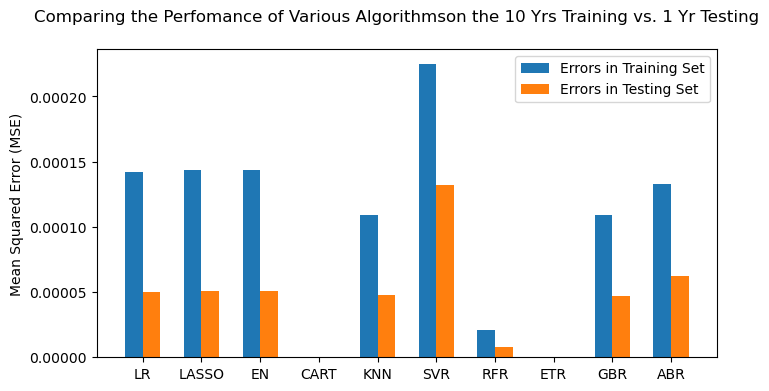

In [215]:
#finally we visualize it
fig = plt.figure(figsize = [8, 4])

ind = np.arange(len(names)
               )

width = 0.30

fig.suptitle\
    ("Comparing the Perfomance of Various Algorithms\
on the 10 Yrs Training vs. 1 Yr Testing")

ax = fig.add_subplot(111)

(plt
 .bar(ind - width/2,
      train_results,
      width = width,
      label = "Errors in Training Set")
)

(plt
 .bar(ind + width/2,
      test_results,
      width = width,
      label = "Errors in Testing Set")
)

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error (MSE)")

plt.show()

In [216]:
models

[('LR', LinearRegression()),
 ('LASSO', Lasso()),
 ('EN', ElasticNet()),
 ('CART', DecisionTreeRegressor()),
 ('KNN', KNeighborsRegressor()),
 ('SVR', SVR()),
 ('RFR', RandomForestRegressor()),
 ('ETR', ExtraTreesRegressor()),
 ('GBR', GradientBoostingRegressor()),
 ('ABR', AdaBoostRegressor())]

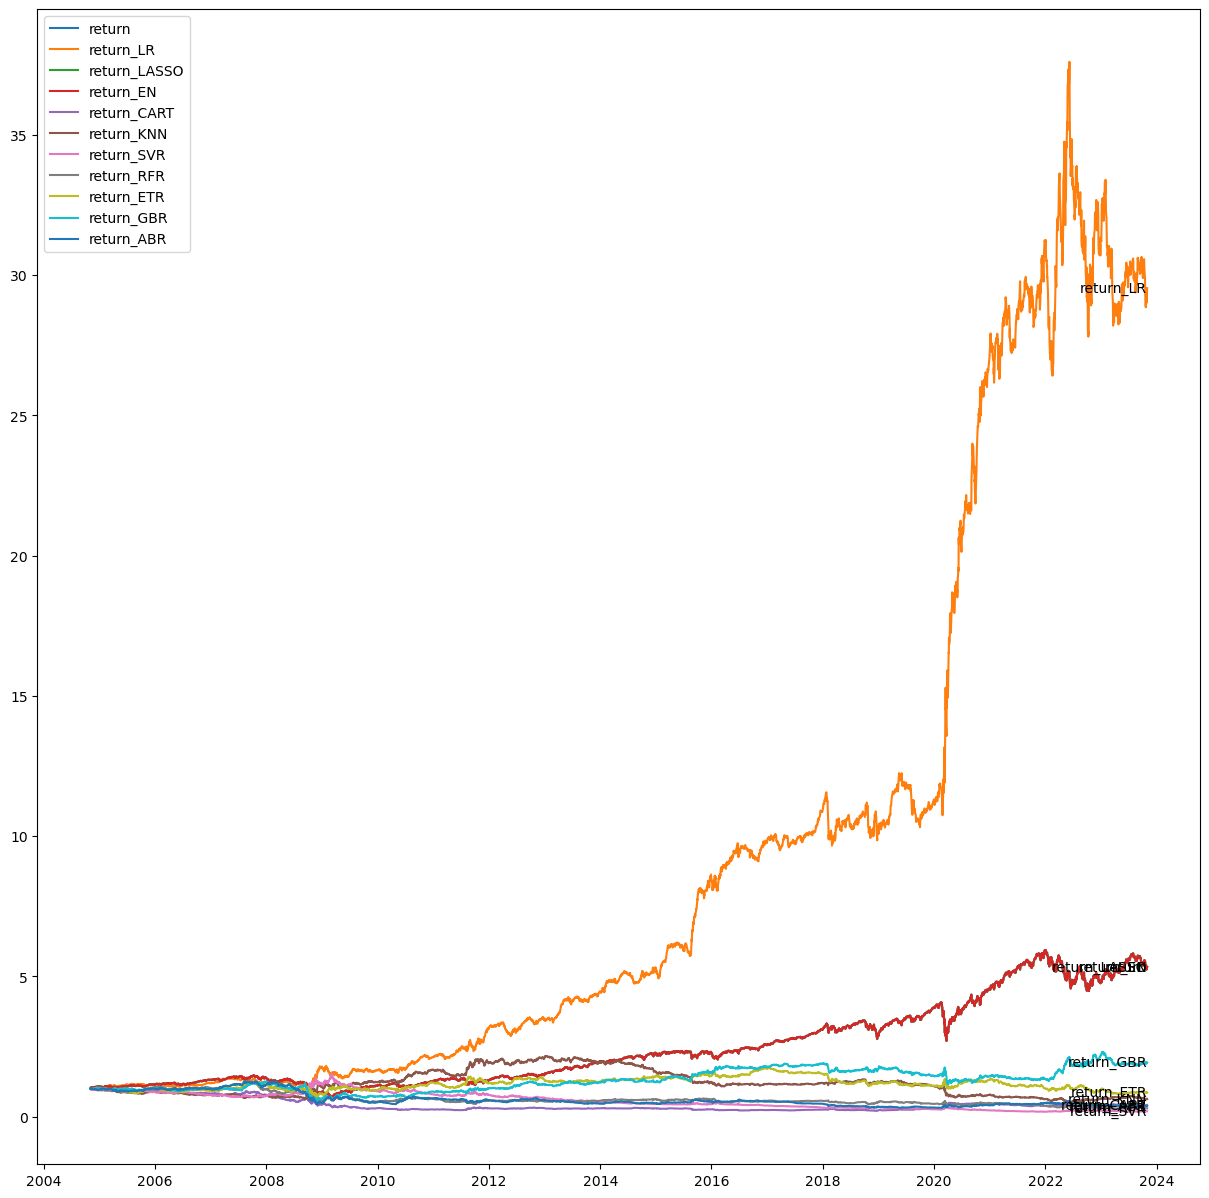

In [217]:
backtest_signal = pd.DataFrame(Y_test)

cols = []
for i in range(len(models)):
    res = models[i][1].fit(X_train, Y_train)
    predicted = res.predict(X_test)
    predicted = pd.DataFrame(predicted, index=Y_test.index)
    
    col = models[i][0]
    cols.append(col)
    backtest_signal[col] = np.sign(predicted)
    
backtest_return = backtest_signal[['return']]
for col in cols:
    backtest_return[f"return_{col}"] =\
        backtest_return["return"]*backtest_signal[col]
plt.figure(figsize=[15,15])
starting_amt = 1e5
closing_amt = []
for name in backtest_return.columns:
    plt.plot(np.exp(backtest_return[f"{name}"].cumsum()), label = f"{name}")
    # Add labels on the plot
    final_factor = np.exp(backtest_return[f"{name}"].cumsum()).iloc[-1]
    closing_amt += [final_factor * starting_amt]
    plt.text(backtest_return.index[-1], final_factor,
             f"{name}", ha='right', va='center')
plt.legend()
plt.show()

> Based on the above result, model choice would be 
* `LinearRegression (LR)`

In [218]:
models[0]

('LR', LinearRegression())

In [219]:
X_choices = {
    'Choice0': ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6'],
    'Choice1': ['lag_4', 'AAPL', 'XEL', 'ADBE', '^N225', '^TNX'],
    'Choice2': ['lag_4', 'lag_6', 'AAPL', 'XEL', 'ADBE', '^N225', '^TNX'],
    'Choice3': ['lag_4', 'lag_6', 'lg_volm_7', 'AAPL',
                'XEL', 'ADBE', '^N225', '^TNX'],  
    'Choice4': ['lag_1', 'lag_2', 'lag_4', 'lag_6', 'lg_volm_7',
                'AAPL', 'XEL', 'ADBE', '^N225', '^TNX'],
    
    'Choice5': ['lag_1', 'lag_2', 'lag_4', 'lag_6', 'lag_7', 
                'lg_volm_7', 'AAPL', 'XEL', 'ADBE', 'AAPL_3DT', 
                'XEL_3DT', 'ADBE_3DT', '^N225', '^TNX'],
    
    'ChoiceAll': ['lag_1', 'lg_volm_1', 'lag_2', 
                  'lg_volm_2', 'lag_3', 'lg_volm_3',
                  'lag_4', 'lg_volm_4', 'lag_5', 
                  'lg_volm_5', 'lag_6', 'lg_volm_6',
                  'lag_7', 'lg_volm_7', 'AAPL', 'XEL', 
                  'ADBE', 'AAPL_3DT', 'XEL_3DT',
                  'ADBE_3DT', 'AAPL_6DT', 'XEL_6DT', 
                  'ADBE_6DT', 'AAPL_12DT', 'XEL_12DT',
                  'ADBE_12DT', 'DEXJPUS', 'DEXUSUK', 
                  '^VIX', '^N225', '^TNX', '^VIX_3DT',
                  '^N225_3DT', '^TNX_3DT', '^VIX_6DT', 
                  '^N225_6DT', '^TNX_6DT', '^VIX_12DT',
                  '^N225_12DT', '^TNX_12DT', 'SPY_MA21', 'SPY_MA63',
                  'SPY_MA252', 'SPY_EMA10', 'SPY_EMA30', 'SPY_EMA200'],
}

In [220]:
Y_name = 'return'
Y_clean = data[Y_name]
Y_train, Y_test =\
    (Y_clean[:train1], 
     Y_clean[train1:test]
    )

backtest_sig_1yr = pd.DataFrame(Y_test)
backtest_1yr = backtest_sig_1yr[['return']]
backtest_1yr = backtest_1yr.rename(columns={'return': 'SPY return'})
for key, X_choice in X_choices.items():

    X_clean = data[X_choice]
    X_train, X_test =\
        (X_clean[:train1], 
         X_clean[train1:test]
        )

    cols = []

    res = models[0][1].fit(X_train, Y_train)
    predicted = res.predict(X_test)
    predicted = pd.DataFrame(predicted, index=Y_test.index)
    
    col = models[0][0]
    cols.append(key)
    backtest_sig_1yr[key] = np.sign(predicted)


    for col in cols:
        backtest_1yr[f"LR_{col}"] =\
            backtest_1yr["SPY return"]*backtest_sig_1yr[col]
backtest_1yr

,SPY return,LR_Choice0,LR_Choice1,LR_Choice2,LR_Choice3,LR_Choice4,LR_Choice5,LR_ChoiceAll
Date,,,,,,,,
2003-11-03,0.006531,0.006531,0.006531,0.006531,0.006531,0.006531,0.006531,0.006531
2003-11-04,-0.002172,0.002172,-0.002172,-0.002172,-0.002172,-0.002172,-0.002172,-0.002172
2003-11-05,0.000756,0.000756,0.000756,0.000756,0.000756,0.000756,0.000756,-0.000756
2003-11-06,0.005278,0.005278,0.005278,0.005278,0.005278,0.005278,-0.005278,-0.005278
2003-11-07,-0.007453,-0.007453,0.007453,0.007453,0.007453,0.007453,0.007453,0.007453
...,...,...,...,...,...,...,...,...
2004-10-26,0.015177,0.015177,-0.015177,-0.015177,-0.015177,0.015177,-0.015177,-0.015177
2004-10-27,0.011941,0.011941,-0.011941,-0.011941,-0.011941,-0.011941,-0.011941,-0.011941
2004-10-28,0.003007,-0.003007,0.003007,0.003007,0.003007,-0.003007,0.003007,-0.003007


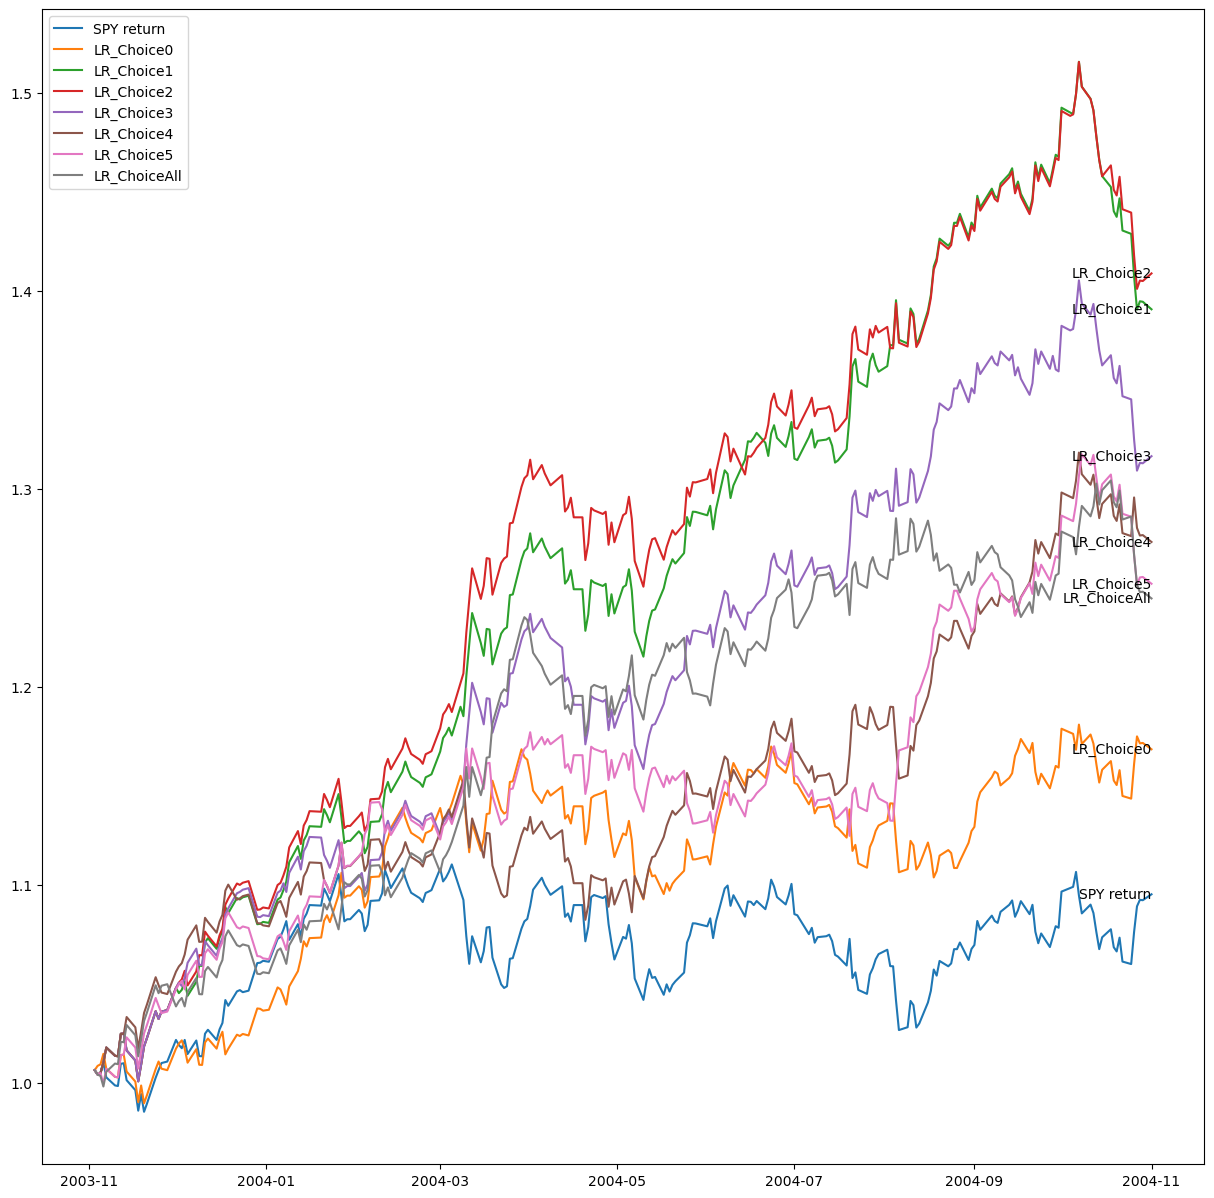

In [221]:
plt.figure(figsize=[15,15])
starting_amt = 1e5
closing_amt = []
for name in backtest_1yr.columns:
    plt.plot(np.exp(backtest_1yr[f"{name}"].cumsum()), label = f"{name}")
    # Add labels on the plot
    final_factor = np.exp(backtest_1yr[f"{name}"].cumsum()).iloc[-1]
    closing_amt += [final_factor * starting_amt]
    plt.text(backtest_1yr.index[-1], final_factor, f"{name}", ha='right', va='center')
plt.legend()
plt.show()

In [222]:
performance_test1yr = cal_Sharpe_lg_Rtn(backtest_1yr, starting_amt)
DD_result1yr = []
for strategy in performance_test1yr[0]:
    DD_result1yr += [cal_MDD(performance_test1yr[0][[strategy]])]

In [223]:
performance_metrics_1yr =\
(
    pd.DataFrame({'Features': ['SPY self'] + list(X_choices.keys()),
                  'CAGR%': performance_test1yr[2],
                  'Sharpe Ratio': performance_test1yr[3],
                  'Sortino Ratio': performance_test1yr[-1],
                  'Max Drawdown%': 
                      [DD_result1yr[i][1]\
                       .sort_values(by = 'DD%')\
                       .iloc[0, -1] for i in range(len(DD_result1yr))],
                  'Max Drawdown$': 
                      [DD_result1yr[i][1]\
                       .sort_values(by = 'DD_Max')\
                       .iloc[0, -2] for i in range(len(DD_result1yr))],
                  'Max Drawdown (Days)': 
                      [DD_result1yr[i][1]\
                       .sort_values(by = 'Days')\
                       .iloc[-1, -3] for i in range(len(DD_result1yr))],
                  'Multiples of Invested Capital': 
                      performance_test1yr[0].iloc[-1, :]/starting_amt
                 })
)
performance_metrics_1yr = performance_metrics_1yr.set_index('Features', drop = True)

In [224]:
performance_metrics_1yr

,CAGR%,Sharpe Ratio,Sortino Ratio,Max Drawdown%,Max Drawdown$,Max Drawdown (Days),Multiples of Invested Capital
Features,,,,,,,
SPY self,9.564030,0.805422,1.145048,-7.530582,-8362.302374,238,1.095366
Choice0,16.906900,1.381025,2.042474,-6.487857,-7581.639655,85,1.168569
Choice1,39.195200,2.960968,4.790031,-8.253919,-12510.136373,53,1.390691
Choice2,41.014753,3.081985,4.925919,-7.560017,-11457.804270,66,1.408820
Choice3,31.754065,2.456393,3.875258,-6.835689,-9606.198295,66,1.316546
Choice4,27.406834,2.152032,3.343849,-6.115996,-7051.777117,76,1.273223
Choice5,25.290332,2.000739,3.086288,-5.001445,-6589.201231,130,1.252130
ChoiceAll,24.547707,1.947075,3.015627,-4.843597,-5983.142443,85,1.244728


> Choice on feature sets with testing result
* Choice2
* Choice1

## <a id = "p2">2. </a> <font color = "green"> Backtest </font>  [back to table of contents](#top)

# Performance Metrics:

1. Compound Annual Growth Rate (assume 252 days = 1 year) 
2. Sharpe Ratio (annualised using np.sqrt(252))
3. Sortino Ratio (annualised using np.sqrt(252)
4. Max Drawdown by %
5. Max Drawdown by $
6. Max Drawdown by Days
7. Multiple of Invested Capital (MoIC, = Final NAV/Initial NAV, expressed as multiple of base =1.0x). 

In [225]:
Y_name = 'return'
Y_clean = data[Y_name]
Y_train, Y_test =\
    (Y_clean[:test], 
     Y_clean[test:]
    )

backtest_signal = pd.DataFrame(Y_test)
backtest_return = backtest_signal[['return']]
backtest_return = backtest_return.rename(columns={'return': 'SPY return'})
for key, X_choice in X_choices.items():

    X_clean = data[X_choice]
    X_train, X_test =\
        (X_clean[:test], 
         X_clean[test:]
        )

    cols = []

    res = models[0][1].fit(X_train, Y_train)
    predicted = res.predict(X_test)
    predicted = pd.DataFrame(predicted, index=Y_test.index)
    
    col = models[0][0]
    cols.append(key)
    backtest_signal[key] = np.sign(predicted)


    for col in cols:
        backtest_return[f"LR_{col}"] =\
            backtest_return["SPY return"]*backtest_signal[col]
backtest_return

,SPY return,LR_Choice0,LR_Choice1,LR_Choice2,LR_Choice3,LR_Choice4,LR_Choice5,LR_ChoiceAll
Date,,,,,,,,
2004-11-01,0.002735,-0.002735,-0.002735,0.002735,0.002735,-0.002735,-0.002735,-0.002735
2004-11-02,0.000352,-0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352
2004-11-03,0.012515,-0.012515,0.012515,0.012515,0.012515,0.012515,0.012515,0.012515
2004-11-04,0.013562,-0.013562,-0.013562,-0.013562,-0.013562,-0.013562,-0.013562,-0.013562
2004-11-05,0.006244,-0.006244,-0.006244,-0.006244,-0.006244,-0.006244,-0.006244,-0.006244
...,...,...,...,...,...,...,...,...
2023-10-25,-0.014456,-0.014456,0.014456,0.014456,0.014456,0.014456,0.014456,0.014456
2023-10-26,-0.012047,-0.012047,-0.012047,-0.012047,-0.012047,-0.012047,-0.012047,0.012047
2023-10-27,-0.004543,-0.004543,-0.004543,-0.004543,-0.004543,-0.004543,-0.004543,0.004543


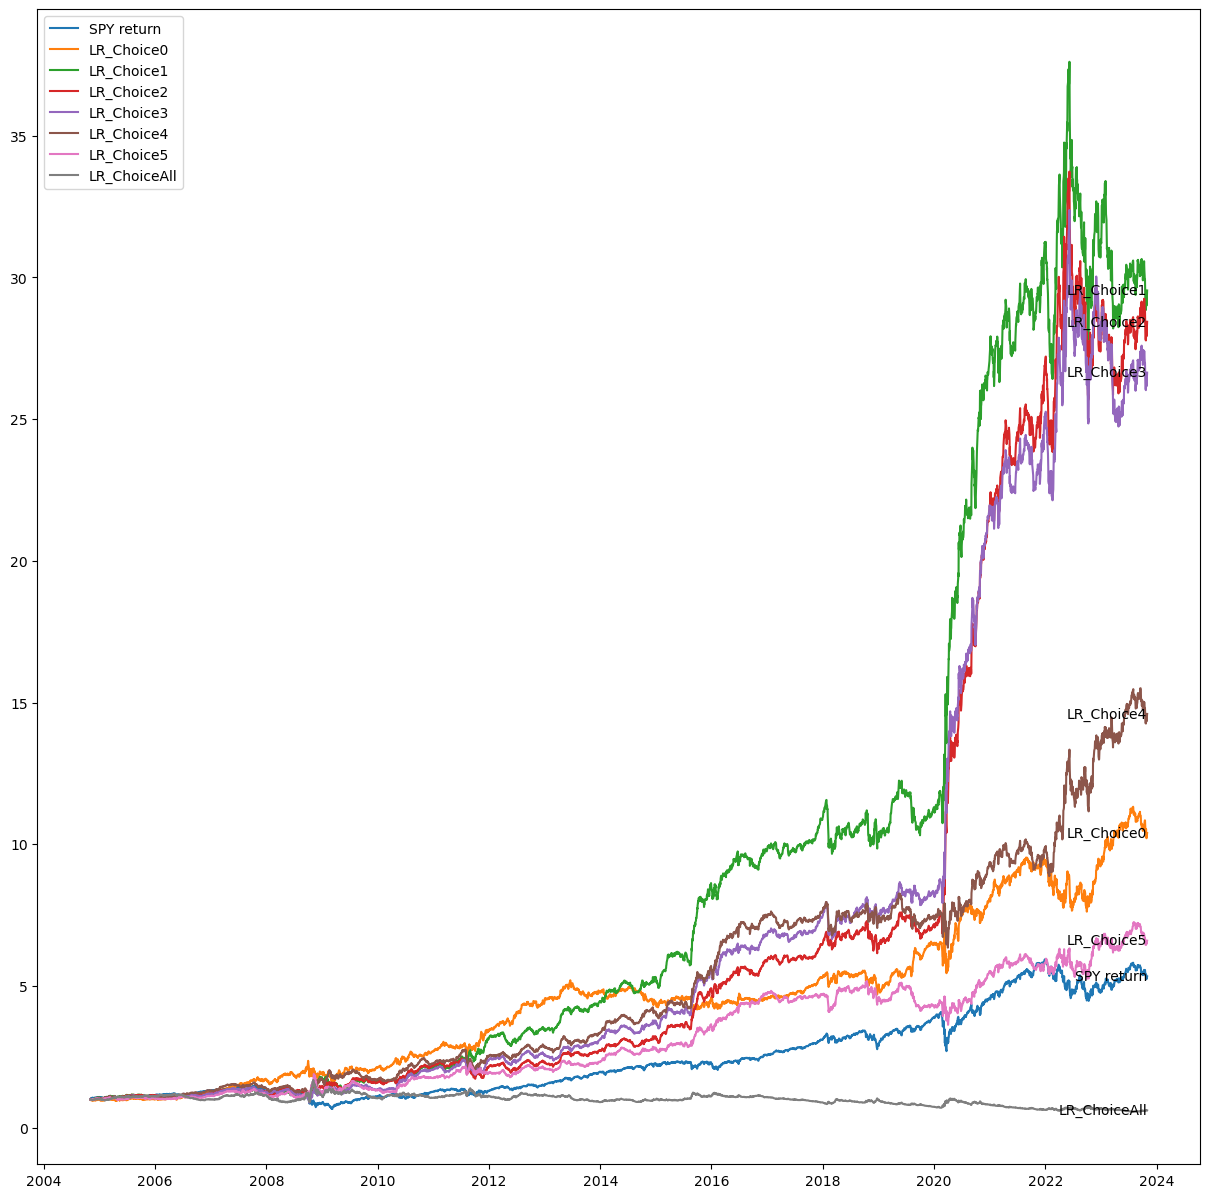

In [226]:
plt.figure(figsize=[15,15])
starting_amt = 1e5
closing_amt = []
for name in backtest_return.columns:
    plt.plot(np.exp(backtest_return[f"{name}"].cumsum()), label = f"{name}")
    # Add labels on the plot
    final_factor = np.exp(backtest_return[f"{name}"].cumsum()).iloc[-1]
    closing_amt += [final_factor * starting_amt]
    plt.text(backtest_return.index[-1], final_factor, f"{name}", ha='right', va='center')
plt.legend()
plt.show()

In [227]:
result_dict = {}
name_list = list(backtest_return.columns)
for i in range(len(closing_amt)):
    result_dict[name_list[i]]=closing_amt[i]
    
result_df = pd.DataFrame([result_dict]).T
result_df.columns = ['cumulative capital']    
result_df.sort_values(by = 'cumulative capital', ascending = False)

,cumulative capital
LR_Choice1,2.954051e+06
LR_Choice2,2.843681e+06
LR_Choice3,2.664198e+06
LR_Choice4,1.459680e+06
LR_Choice0,1.039713e+06
LR_Choice5,6.595983e+05
SPY return,5.333966e+05
LR_ChoiceAll,6.078262e+04


In [228]:
backtest_return

,SPY return,LR_Choice0,LR_Choice1,LR_Choice2,LR_Choice3,LR_Choice4,LR_Choice5,LR_ChoiceAll
Date,,,,,,,,
2004-11-01,0.002735,-0.002735,-0.002735,0.002735,0.002735,-0.002735,-0.002735,-0.002735
2004-11-02,0.000352,-0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352
2004-11-03,0.012515,-0.012515,0.012515,0.012515,0.012515,0.012515,0.012515,0.012515
2004-11-04,0.013562,-0.013562,-0.013562,-0.013562,-0.013562,-0.013562,-0.013562,-0.013562
2004-11-05,0.006244,-0.006244,-0.006244,-0.006244,-0.006244,-0.006244,-0.006244,-0.006244
...,...,...,...,...,...,...,...,...
2023-10-25,-0.014456,-0.014456,0.014456,0.014456,0.014456,0.014456,0.014456,0.014456
2023-10-26,-0.012047,-0.012047,-0.012047,-0.012047,-0.012047,-0.012047,-0.012047,0.012047
2023-10-27,-0.004543,-0.004543,-0.004543,-0.004543,-0.004543,-0.004543,-0.004543,0.004543


In [229]:
(backtest_return.index[-1] - backtest_return.index[0]).days

6938

In [230]:
performance = cal_Sharpe_lg_Rtn(backtest_return, starting_amt)
performance[0]

,SPY return,LR_Choice0,LR_Choice1,LR_Choice2,LR_Choice3,LR_Choice4,LR_Choice5,LR_ChoiceAll
Date,,,,,,,,
2004-11-01,100273.887983,9.972686e+04,9.972686e+04,1.002739e+05,1.002739e+05,9.972686e+04,99726.860114,99726.860114
2004-11-02,100309.221148,9.969173e+04,9.976200e+04,1.003092e+05,1.003092e+05,9.976200e+04,99762.000525,99762.000525
2004-11-03,101572.486412,9.845186e+04,1.010184e+05,1.015725e+05,1.015725e+05,1.010184e+05,101018.374250,101018.374250
2004-11-04,102959.393426,9.712567e+04,9.965761e+04,1.002043e+05,1.002043e+05,9.965761e+04,99657.613594,99657.613594
2004-11-05,103604.245585,9.652114e+04,9.903733e+04,9.958057e+04,9.958057e+04,9.903733e+04,99037.326009,99037.326009
...,...,...,...,...,...,...,...,...
2023-10-25,532567.544634,1.038097e+06,2.949459e+06,2.839261e+06,2.660057e+06,1.457411e+06,658573.056003,60877.246879
2023-10-26,526190.253768,1.025666e+06,2.914141e+06,2.805262e+06,2.628204e+06,1.439959e+06,650686.897755,61615.063491
2023-10-27,523805.153212,1.021017e+06,2.900932e+06,2.792546e+06,2.616291e+06,1.433432e+06,647737.482272,61895.622247


In [233]:
test = cal_MDD(performance[0][['SPY return']])
test[1].sort_values(by = 'DD%')

,S/N,DD_start,DD_end,Days,DD_Max,DD%
53,54,2007-10-10,2012-08-16,1772,-80722.323359,-55.189473
208,209,2020-02-20,2020-08-10,172,-137183.821205,-33.717282
258,259,2022-01-04,2023-10-31,665,-145261.210471,-24.496388
183,184,2018-09-21,2019-04-12,203,-66350.254329,-19.348906
122,123,2015-07-21,2016-04-18,272,-30451.661194,-13.022926
...,...,...,...,...,...,...
63,64,2013-02-11,2013-02-12,1,-31.401852,-0.019745
116,117,2015-02-23,2015-02-24,1,-32.696071,-0.014204
127,128,2016-07-13,2016-07-14,1,-33.688631,-0.013947
156,157,2017-07-17,2017-07-18,1,-34.408723,-0.012221


In [234]:
DD_result = []
for strategy in performance[0]:
    DD_result += [cal_MDD(performance[0][[strategy]])]
    

In [235]:
DD_result[0][1].sort_values(by = 'DD_Max')

,S/N,DD_start,DD_end,Days,DD_Max,DD%
258,259,2022-01-04,2023-10-31,665,-145261.210471,-24.496388
208,209,2020-02-20,2020-08-10,172,-137183.821205,-33.717282
53,54,2007-10-10,2012-08-16,1772,-80722.323359,-55.189473
183,184,2018-09-21,2019-04-12,203,-66350.254329,-19.348906
213,214,2020-09-03,2020-11-11,69,-41026.212907,-9.440443
...,...,...,...,...,...,...
156,157,2017-07-17,2017-07-18,1,-34.408723,-0.012221
127,128,2016-07-13,2016-07-14,1,-33.688631,-0.013947
116,117,2015-02-23,2015-02-24,1,-32.696071,-0.014204
63,64,2013-02-11,2013-02-12,1,-31.401852,-0.019745


In [236]:
performance_metrics =\
(
    pd.DataFrame({'Features': ['SPY self'] + list(X_choices.keys()),
                  'CAGR%': performance[2],
                  'Sharpe Ratio': performance[3],
                  'Sortino Ratio': performance[-1],
                  'Max Drawdown%': 
                      [DD_result[i][1]\
                       .sort_values(by = 'DD%')\
                       .iloc[0, -1] for i in range(len(DD_result))],
                  'Max Drawdown$': 
                      [DD_result[i][1]\
                       .sort_values(by = 'DD_Max')\
                       .iloc[0, -2] for i in range(len(DD_result))],
                  'Max Drawdown (Days)': 
                      [DD_result[i][1]\
                       .sort_values(by = 'Days')\
                       .iloc[-1, -3] for i in range(len(DD_result))],
                  'Multiples of Invested Capital': 
                      performance[0].iloc[-1, :]/starting_amt
                 })
)
performance_metrics = performance_metrics.set_index('Features', drop = True)

> Performance Metrics

In [237]:
performance_metrics

,CAGR%,Sharpe Ratio,Sortino Ratio,Max Drawdown%,Max Drawdown$,Max Drawdown (Days),Multiples of Invested Capital
Features,,,,,,,
SPY self,9.206693,0.552968,0.776963,-55.189473,-145261.210471,1772,5.333966
Choice0,13.109379,0.734316,1.099948,-34.035644,-194304.302242,1626,10.397130
Choice1,19.496988,1.017007,1.581505,-37.286718,-980283.339641,533,29.540511
Choice2,19.257846,1.006356,1.542870,-29.749871,-805872.219766,645,28.436811
Choice3,18.849504,0.988598,1.514798,-38.343854,-763902.281359,509,26.641983
Choice4,15.146362,0.826447,1.251008,-40.793996,-217966.090834,476,14.596800
Choice5,10.433625,0.610423,0.908563,-35.432935,-154624.414863,912,6.595983
ChoiceAll,-2.585212,-0.037707,-0.057614,-66.846193,-112349.113697,5473,0.607826


## <a id = "p3">3. </a> <font color = "green"> Top Strategy (ML) </font>  [back to table of contents](#top)

Sensible features will boost the performance, while noise features will reduce the performance. Nevertheless, from the performance metrics table  above we can see most of the relative features set will result in beating the market in the backtest.

> recall on feature choices:

In [238]:
for key, value in X_choices.items():
    print (key, value)

Choice0 ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']
Choice1 ['lag_4', 'AAPL', 'XEL', 'ADBE', '^N225', '^TNX']
Choice2 ['lag_4', 'lag_6', 'AAPL', 'XEL', 'ADBE', '^N225', '^TNX']
Choice3 ['lag_4', 'lag_6', 'lg_volm_7', 'AAPL', 'XEL', 'ADBE', '^N225', '^TNX']
Choice4 ['lag_1', 'lag_2', 'lag_4', 'lag_6', 'lg_volm_7', 'AAPL', 'XEL', 'ADBE', '^N225', '^TNX']
Choice5 ['lag_1', 'lag_2', 'lag_4', 'lag_6', 'lag_7', 'lg_volm_7', 'AAPL', 'XEL', 'ADBE', 'AAPL_3DT', 'XEL_3DT', 'ADBE_3DT', '^N225', '^TNX']
ChoiceAll ['lag_1', 'lg_volm_1', 'lag_2', 'lg_volm_2', 'lag_3', 'lg_volm_3', 'lag_4', 'lg_volm_4', 'lag_5', 'lg_volm_5', 'lag_6', 'lg_volm_6', 'lag_7', 'lg_volm_7', 'AAPL', 'XEL', 'ADBE', 'AAPL_3DT', 'XEL_3DT', 'ADBE_3DT', 'AAPL_6DT', 'XEL_6DT', 'ADBE_6DT', 'AAPL_12DT', 'XEL_12DT', 'ADBE_12DT', 'DEXJPUS', 'DEXUSUK', '^VIX', '^N225', '^TNX', '^VIX_3DT', '^N225_3DT', '^TNX_3DT', '^VIX_6DT', '^N225_6DT', '^TNX_6DT', '^VIX_12DT', '^N225_12DT', '^TNX_12DT', 'SPY_MA21', 'SPY_MA63', 'SPY_MA252'

Top strategy (ML):

1. Overall Best: Feature Choice 2
2. Best Return: Feature Choice 1
3. Least Drawdown: Feature Choice 2

## <a id = "p4">4. </a> <font color = "green"> Self-Critique </font>  [back to table of contents](#top)

> Goal: to build replicable trading strategy with excellent backtest result, while minimizing overfit

1. trading account started from `$100,000`
2. trading period from `November 2004` through `October 2023`.
3. training period from `November 1993` through `October 2004`.

#### Feature Engineering
1. endogenous lagged data to capture market view on `SPY`
2. typical assets from different industry to reflect market condition
3. Major currency exchange rates to reflect how US is favored over other markets
4. Major indices (VIX, JP225, T-bill) to further capture macroeconomic conditions

#### Model training and selection¶
1. model needs to be ready before targeted trading period from `2004 to 2023`
2. Training data is selected from `1993 to 2003`
3. Testing data is selected from `2003 to 2004`
4. Based on testing result `LinearRegression (LR)` is selected 
5. The strategy is deployed from 2004 to 2023 for continuous `20` years

> Survivorship Bias

1. The feature choice could be an example of `survivorship bias`. I have chosen THREE companies that have existed for 30 years. But by the time of trade starts, correctly select on such X features shall be a myth.
2. One way to reduce the bias is to update such features with a "Rolling-Window". So as to related the target indices back to the proper set of features.
3. The `Lookahead Bias` and `Market Regime Shift` effects might not be related to my ML strategy.

> Future improvement

* Rolling Window Method: could be a way of updating on trading models.
* Feature Fine tuning: could be a way of improving on model performance.